# Deep Convolutational Neural Networks

"LeNet" is a convolutional neural network for the MNIST dataset developed by Yann LeCun. It operates as follow:

1) Turn the 28x28 input images into 20 <i>feature maps</i> using 20 different convolutional kernels of size 5x5 (500 parameters plus 20 for the bias values) with ReLu activation function.

2)Use MaxPooling with a pool size of 2x2 and 2x2 stride to consolidate the information. The "2x2" stride moves a "2x2" window along both axes of the image without overlap, resulting in 20 14x14 feature maps.

3) Turn the 20 14x14 feature maps into 50 14x14 feature maps.

4) Use again maxpooling to create 20 7x7 feature maps.

5) Flatten all neurons into a single vector of 980 neurons and run them into a hidden layer of 500 neurons with ReLu activation. 

6) Adding a final hidden layer with 10 neurons and Softmax activation for 1,256,080 parameters total. 

This network is shown below
<center>
    <img src="figs/cnn.svg" width="75%">
</center>


In [19]:
#from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# From "Deeplearning with Keras"
NB_EPOCH = 5
BATCH_SIZE = 128
VERBOSE = 1
OPTIMIZER = Adam()
VALIDATION_SPLIT=0.2
IMG_ROWS, IMG_COLS = 28, 28 # input image dimensions
NB_CLASSES = 10 # number of outputs = number of digits
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 1)
# data: shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#K.set_image_dim_ordering("th") # comment this line out for new version of Keras
# consider them as float and normalize
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
# we need a 60K x [1 x 28 x 28] shape as input to the CONVNET
X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, NB_CLASSES)
y_test = np_utils.to_categorical(y_test, NB_CLASSES)

11493376/11490434 [==============================] - 2s 0us/step
60000 train samples
10000 test samples


In [50]:
from keras.models import load_model

# initialize the optimizer and model
model = Sequential()
# CONV => RELU => POOL
model.add(Conv2D(20, kernel_size=5, padding="same",input_shape=INPUT_SHAPE))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding="same"))
# CONV => RELU => POOL
model.add(Conv2D(50, kernel_size=5, padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="same"))
# Flatten => RELU layers
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))
# a softmax classifier
model.add(Dense(NB_CLASSES))
model.add(Activation("softmax"))
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,metrics=["accuracy"])
model.summary()

#model = load_model('LeNet.h5')
history = model.fit(X_train, y_train,batch_size=BATCH_SIZE, epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
score = model.evaluate(X_test, y_test, verbose=VERBOSE)


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 28, 28, 20)        520       
_________________________________________________________________
activation_30 (Activation)   (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_31 (Activation)   (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2450)            

In [51]:
print(score[1])
model.save('LeNet.h5')

0.9915000200271606


Test score: 0.025546890637765683
Test accuracy: 0.9915000200271606
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


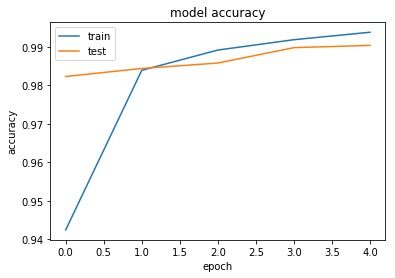

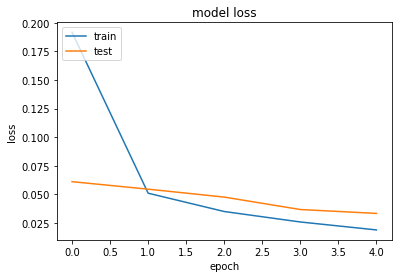

In [52]:
print("Test score:", score[0])
print('Test accuracy:', score[1])
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Visualizing individual layers

Now that we have a rough idea on what a convolution kernel would actually do to an image, it would be interesting to visualize the kernels that LeNet has actually found. The code below has been inspired from the article <a href="https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/">How to visualize filters and feature maps in convolutional neural networks</a>, and will show the kernels of the first convolutional layers as well as their application to the input image. 

In [53]:
from keras.models import load_model

model = load_model('LeNet.h5')

for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    print(layer.name, filters.shape)
    break # grabs only the first filter

conv2d_19 (5, 5, 1, 20)


### First Convolution

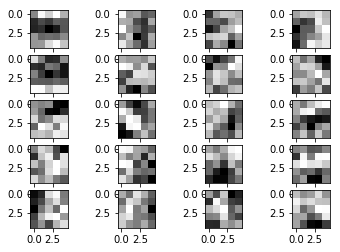

In [54]:
for I in range(5):
    for J in range(4):
        plt.subplot(5,4,I*4+J+1)
        plt.imshow(filters[:,:,0,I*4+J],cmap='gray')

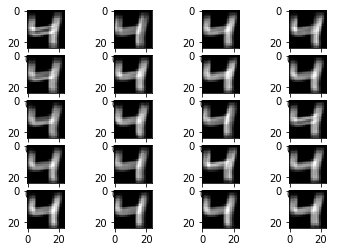

In [56]:
from scipy import signal

for I in range(5):
    for J in range(4):
        plt.subplot(5,4,I*4+J+1)
        plt.imshow(signal.convolve2d(X_train[2,:,:,0],filters[:,:,0,I*4+J],mode='valid'),cmap='gray')

### First MaxPooling



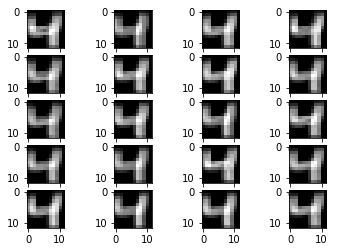

In [58]:
import skimage.measure

for I in range(5):
    for J in range(4):
        plt.subplot(5,4,I*4+J+1)
        plt.imshow(skimage.measure.block_reduce(signal.convolve2d(X_train[2,:,:,0],filters[:,:,0,I*4+J],mode='valid'), (2,2), np.max),cmap='gray')


### Second Convolution

Inspecting the second convolutional layer with 50 feature maps, we find 20x50 5x5 kernels as each feature map is a weighted sum of all previous 20 feature maps. We will instead build an intermediate model that ends at the fifth layer and visualize the 50 feature maps directly. 

In [77]:
from keras.models import Model

intermediate_layer_model = Model(inputs=model.input,outputs=model.layers[4].output)
intermediate_output = intermediate_layer_model.predict(np.expand_dims( X_train[2,:,:,:], axis=0))
#intermediate_output = intermediate_layer_model.predict(X_train[:,:,:,:])




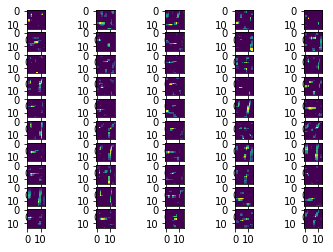

In [79]:
for I in range(10):
    for J in range(5):
        plt.subplot(10,5,I*5+J+1)
        plt.imshow(intermediate_output[0,:,:,I*5+J])

## Convolutional Neural Networks and Training Set Size

To directly compare DNNs and CNNs we train two networks with a similar amount of parameters (126,414 for the CNN and 126,415 for the DNN) with different numbers of training elements. This can be achieved by tuning the validation split, resulting in training sets as little as 600 elements. When using the same optimizers (Adam), it turns out that the DNN inititially gets better performance until around 10000 training examples are provided. 

Contrary to intuition, however, increasing CNN complexity does not require more training data to yield good predictors, but a highly complex CNN can be trained with surprisingly few instances. 

In [22]:

validation_splits=[0.99, 0.98, 0.95, 0.90, 0.8]
score=np.zeros((2,len(validation_splits)))

#for I, training_size in enumerate(training_sizes):
training_size=60000
for I, vs in enumerate(validation_splits):
    # A simple DNN
    model = Sequential()
    model.add(Dense(159, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    #model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy'])
    history = model.fit(X_train[:training_size,:,:,0].reshape(training_size,784), y_train[:training_size,:], batch_size=128, epochs=25, verbose=0, validation_split=vs)
    score[0,I] = model.evaluate(X_test[:,:,:,0].reshape(10000,784), y_test, verbose=1)[1]


    # A simple CNN
    model = Sequential()
    # CONV => RELU => POOL
    model.add(Conv2D(10, kernel_size=5, padding="same",input_shape=INPUT_SHAPE))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding="same"))
    # CONV => RELU => POOL
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation("relu"))
    # a softmax classifier
    model.add(Dense(NB_CLASSES))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(),metrics=["accuracy"])
    #model.summary()
    history = model.fit(X_train[:training_size,:,:,:], y_train[:training_size,:],batch_size=128, epochs=5,verbose=0, validation_split=vs)
    score[1,I] = model.evaluate(X_test, y_test, verbose=1)[1]




10000/10000 [==============================] - 0s 33us/step


Text(0.5, 0, 'Number of training examples')

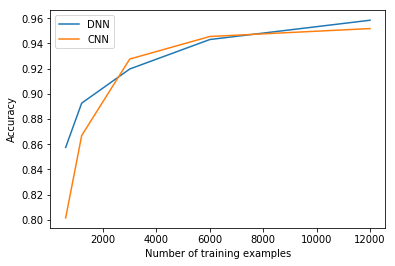

In [23]:
plt.plot([60000-I*60000 for I in validation_splits],score.T)
plt.legend(['DNN','CNN'])
plt.ylabel('Accuracy')
plt.xlabel('Number of training examples')

In [25]:
validation_splits=[0.99, 0.98, 0.95, 0.90, 0.8]
score=np.zeros((2,len(validation_splits)))

#for I, training_size in enumerate(training_sizes):
training_size=60000
for I, vs in enumerate(validation_splits):
    # A simple DNN
    model = Sequential()
    model.add(Dense(128, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dense(128, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    #model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy'])
    history = model.fit(X_train[:training_size,:,:,0].reshape(training_size,784), y_train[:training_size,:], batch_size=128, epochs=25, verbose=0, validation_split=vs)
    score[0,I] = model.evaluate(X_test[:,:,:,0].reshape(10000,784), y_test, verbose=1)[1]


    # A simple CNN
    model = Sequential()
    # CONV => RELU => POOL
    model.add(Conv2D(20, kernel_size=5, padding="same",input_shape=INPUT_SHAPE))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding="same"))
    # CONV => RELU => POOL
    model.add(Conv2D(50, kernel_size=5, padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding="same"))
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))
    # a softmax classifier
    model.add(Dense(NB_CLASSES))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(),metrics=["accuracy"])
    #model.summary()
    history = model.fit(X_train[:training_size,:,:,:], y_train[:training_size,:],batch_size=128, epochs=5,verbose=0, validation_split=vs)
    score[1,I] = model.evaluate(X_test, y_test, verbose=1)[1]





10000/10000 [==============================] - 1s 78us/step


Text(0.5, 0, 'Number of training examples')

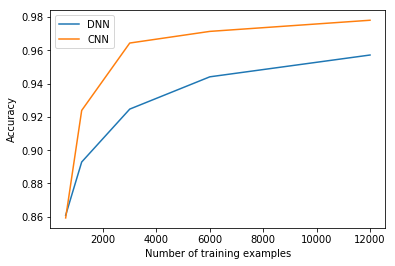

In [26]:
plt.plot([60000-I*60000 for I in validation_splits],score.T)
plt.legend(['DNN','CNN'])
plt.ylabel('Accuracy')
plt.xlabel('Number of training examples')

## CNNs on real images, the CIFAR-10 dataset



x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


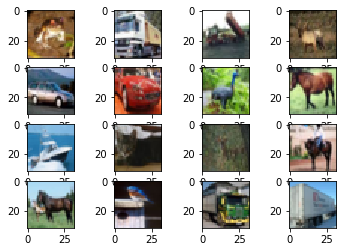

In [2]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt

import os

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

for I in range(4):
    for J in range(4):
        plt.subplot(4,4,I*4+J+1)
        plt.imshow(x_train[I*4+J,:,:,:])

In [29]:
batch_size = 128
num_classes = 10
epochs = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'


model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


opt = keras.optimizers.Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 40s 799us/step - loss: 1.6301 - accuracy: 0.4059 - val_loss: 1.2723 - val_accuracy: 0.5537
Epoch 2/20
50000/50000 [==============================] - 40s 794us/step - loss: 1.1999 - accuracy: 0.5743 - val_loss: 1.0284 - val_accuracy: 0.6395
Epoch 3/20
50000/50000 [==============================] - 40s 794us/step - loss: 1.0178 - accuracy: 0.6435 - val_loss: 0.9164 - val_accuracy: 0.6768
Epoch 4/20
50000/50000 [==============================] - 40s 794us/step - loss: 0.9077 - accuracy: 0.6825 - val_loss: 0.8045 - val_accuracy: 0.7213
Epoch 5/20
50000/50000 [==============================] - 40s 801us/step - loss: 0.8336 - accuracy: 0.7076 - val_loss: 0.7855 - val_accuracy: 0.7293
Epoch 6/20
50000/50000 [==============================] - 40s 794us/step - loss: 0.7744 - accuracy: 0.7285 - val_loss: 0.7286 - val_accuracy: 0.7516
Epoch 7/20
50000/50000 [==============================] 

# Data augmentation

Even though 60000 images are quite a large number, the resulting patterns are tied to specific rotations, scales, and lighting conditions. A simple way to increase robustness of the resulting classifier is to artificially augment training data by rotating and scaling as well as changing the image in other ways. Keras provides such a tool (<code>ImageDataGenerator</code>) which returns an iterator that provides random distortions, following a specified distribution, of an input image. More information on how the data can be transformed can be found here https://keras.io/preprocessing/image/.



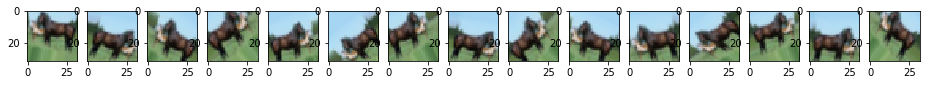

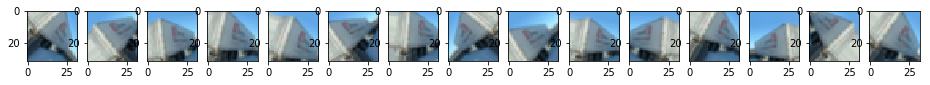

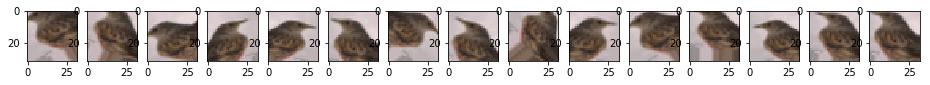

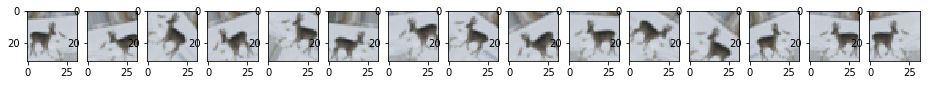

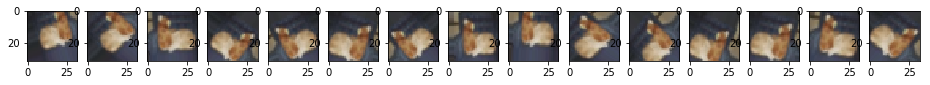

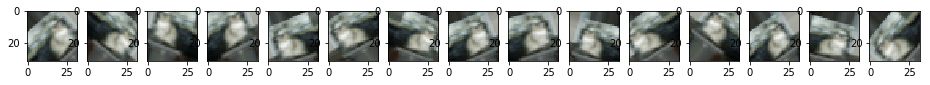

In [31]:
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

for img_id in [12,15,18,20,17,4829]:
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.1, rotation_range=50,
                                       width_shift_range=0.1, height_shift_range=0.2, shear_range=0.2, 
                                       horizontal_flip=True, fill_mode='nearest')

    img_generator = train_datagen.flow(x_train[img_id:img_id+1], y_train[img_id:img_id+1],
                                       batch_size=1)
    img = [next(img_generator) for i in range(0,15)]
    fig, ax = plt.subplots(1,15, figsize=(16, 6))
    l = [ax[i].imshow(img[i][0][0]) for i in range(0,15)]

The code below is an example of actually using generated data such as the one above to improve training. Keras image generator returns an iterator (via the <code>flow()</code>method that can be passed to the <code>generator_fit()</code> function, which returns <code>batch_size</code> random image variations. The drawback of this method is that the learning algorithm does not really train on the original images that have been provided. While this might get better accuracy with new images, overdoing it (like in the example above) will not actually improve performance on the test, which hasn't been distorted in the same way. This can be easily seen by playing with the values below. 

It is also worth noting that in order to really take advantage of a large number of variations, we would actually need to increase the number of instances presented to the network (<code>steps_per_epoch</code> parameter), increasing the time for training. 

In [48]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt

import os

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

batch_size = 128
num_classes = 10
epochs = 20
data_augmentation = True

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model_with_augmentation.h5'


model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


opt = keras.optimizers.Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

datagen = ImageDataGenerator(zoom_range=0.001, rotation_range=2,
                                       width_shift_range=0.005, height_shift_range=0.01, shear_range=0.01, 
                                       horizontal_flip=True, fill_mode='nearest')

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=32),
                     steps_per_epoch=50000/32*1.5, # use 1.5 times as many training images
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Epoch 1/20
2344/2343 [==============================] - 80s 34ms/step - loss: 1.4426 - accuracy: 0.4790 - val_loss: 1.0830 - val_accuracy: 0.6076
Epoch 2/20
2344/2343 [==============================] - 80s 34ms/step - loss: 1.0380 - accuracy: 0.6345 - val_loss: 0.9114 - val_accuracy: 0.6774
Epoch 3/20
2344/2343 [==============================] - 80s 34ms/step - loss: 0.8986 - accuracy: 0.6849 - val_loss: 0.7762 - val_accuracy: 0.7250
Epoch 4/20
2344/2343 [==============================] - 79s 34ms/step - loss: 0.8251 - accuracy: 0.7110 - val_loss: 0.7436 - val_accuracy: 0.7458
Epoch 5/20
2344/2343 [==============================] - 79s 34ms/step - loss: 0.7680 - accuracy: 0.7321 - val_loss: 0.7018 - val_accuracy: 0.7547
Epoch 6/20
2344/2343 [==============================] - 80s 34ms/step - loss: 0.7464 - accuracy: 0.7402 - val_loss: 0.6740 - val_accuracy: 0.7694
Epoch 7/20
2344/2343 [=============================

# Very Deep Convolutional Networks

The networks so far had only two or three convolutional layers. In 2014, researchers have begun to push the depth to 16 or more layers, which is described in the paper <a href="https://arxiv.org/abs/1409.1556">Very Deep Convolutional Networks for Large-Scale Image Recognition</a>. A now famous model, VGG-16, has been trained on the ImageNet dataset, which includes 1000 classes, 1.3 million training images, 50,000 validation and 100,000 test images. Each image is 224x224 pixels with full color and are available as a pre-trained model from the internet. The network has originally been trained using the CAFFE network, but has been converted to keras weights. It is available as <a href="https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3">vgg16_weights.h5</a> online. The file is 528MB giving you an idea how long it will take to train. 

Albeit it is possible to manually define all the layers in keras as specified in the paper and then load the weights manually using <code>model.load_weights()</code>, we will load the model directly and apply it to the image of a cat

<center>
    <img src="figs/cat.jpg">
</center>

In [2]:
import keras
from keras import applications
import cv2, numpy as np
import matplotlib.pyplot as plt

vgg_model = applications.VGG16(weights='imagenet', include_top=True)

im = cv2.resize(cv2.imread('figs/cat.jpg'), (224,224)).astype(np.float32)
im = np.expand_dims(im,axis=0) # adds an empty dimension in front (1,3,224,224)

vgg_model.compile(optimizer=keras.optimizers.Adam(),loss='categorical_crossentropy')

out=vgg_model.predict(im)

print(np.argmax(out))

285


If you actually got "285", you are lucky! Its indeed a cat. How would you know? The original dataset is available at http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz It contains a file <code>synsets.txt</code> as well as <code>synset_words.txt</code>. The first file encodes the ImageNet synsets line by line, with line 285 corresponding to <a href="http://www.image-net.org/explore?wnid=n02123597">n02123597</a>, which you can look up in synset_words.txt ("Siamese cat, Siamese").

While this surely is fascinating, why would you ever go through the effort and download a massive dataset to categorize images that you probably do not need for your application? The answer is <i>transfer learning</i>.